In [1]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset
import json
import random
import os
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms import transforms
from tqdm import tqdm
from PIL import Image


In [2]:
class GymEquipmentDataset(Dataset):
    def __init__(self, transform=None):
        self.images_dir = 'C:/Users/user/Documents/Deep Learning Projects/Gym Equipment Detector/Datasets/'
        self.annotations = json.load(open('C:/Users/user/Documents/Deep Learning Projects/Gym Equipment Detector/annotations.json'))
        self.transform = transform

        self.train_data, self.val_data, self.test_data = self.split_data()

    def split_data(self, split_ratio=(0.8,0.1,0.1)):
        dataset_size = len(self.annotations)
        train_size = int(split_ratio[0] * dataset_size)
        val_size = int(split_ratio[1] * dataset_size)
        test_size = dataset_size - train_size - val_size

        indices = list(range(dataset_size))
        random.shuffle(indices)


        split_indices = {
            'train': indices[:train_size],
            'val': indices[train_size:train_size + val_size],
            'test': indices[-test_size:]
        }

        splits = {}
        for split, idxs in split_indices.items():
            annotations = self._get_annotations([self.annotations[idx] for idx in idxs])
            splits[split] = annotations

        return splits['train'], splits['val'], splits['test']
    
    def _get_annotations(self, data):
        annotations = []
        for items in data:
            img_path =  items['file_name']
            image = Image.open(img_path).convert("RGB")
            image = self.transform(image)

            label = items['category_id']
            annotations.append((
                image,
                label
            ))
        return annotations
    
    

    

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = GymEquipmentDataset(transform=transform)

train_loader = DataLoader(dataset.train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset.val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset.test_data, batch_size=32, shuffle=False)



In [4]:
class EquipmentModelRes34(nn.Module):
    def __init__(self, num_classes=22):
        super(EquipmentModelRes34, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(self._residual_block(self.in_channels, channels, stride))
            self.in_channels = channels
        return nn.Sequential(*layers)

    def _residual_block(self, in_channels, out_channels, stride):
        return ResidualBlock(in_channels, out_channels, stride)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)

        return out

In [5]:

# class EquipmentModelRes34(nn.Module):

#     def __init__(self, num_classes=22):
#         super(EquipmentModelRes34, self).__init__()
#         self.in_channels = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         self.layer1 = self._make_layer(64, 3, stride=1)

#         self.layer2 = self._make_layer(128, 4, stride=2)

#         self.layer3 = self._make_layer(256, 6, stride=2)

#         self.layer4 = self._make_layer(512, 3, stride=2)

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512, num_classes)

#     def _make_layer(self, channels, num_blocks, stride):
#         strides = [stride] + [1] * (num_blocks - 1)
#         layers = []
#         for stride in strides:
#             layers.append(nn.Sequential(
#                 nn.Conv2d(self.in_channels, channels, kernel_size=3, stride=stride, padding=1, bias=False),
#                 nn.BatchNorm2d(channels),
#                 nn.LeakyReLU(inplace=True),
#                 nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
#                 nn.BatchNorm2d(channels),
#                 nn.LeakyReLU(inplace=True)
#             ))
#             self.in_channels = channels
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.pool1(F.relu(self.bn1(self.conv1(x))))

#         x = self.layer1(x)

#         x = self.layer2(x)

#         x = self.layer3(x)

#         x = self.layer4(x)

#         x = self.avgpool(x)

#         x = x.view(x.size(0), -1)

#         x = self.fc(x)
#         return x
    
    
    

In [9]:
model = EquipmentModelRes34()

lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [10]:
epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_accuracies = []
val_accuracies = []
wrong_predictions = []

torch.cuda.is_available()

True

In [11]:
for epoch in range(epochs):

    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images,labels in tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{epochs}'):
        images,labels = images.to(device),labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = lossfun(outputs,labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        _, predicted = torch.max(outputs,1)

        train_correct+= (predicted==labels).sum().item()
        train_total += labels.size(0)

    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct/train_total*100
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        wrong = []
        for images, labels in val_loader:
            cpulabels = labels
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = lossfun(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)

            correct_mask = predicted.eq(labels) 

            for i in range(len(images)):
                if not correct_mask[i]:
                    actual_label = cpulabels[i].item()
                    predicted_label = predicted[i].item()
                    wrong.append((actual_label, predicted_label))
                    
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / val_total*100
        val_accuracies.append(val_accuracy)
        if(val_accuracy>80):
            wrong_predictions.append(wrong)
    
    print(f'Epoch {epoch + 1}/{epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # if val_accuracy>92 :
    #     print('Val Accuracy Is Higher than 95%! Ending Training.......')
    #     break
    
print('Training complete!')

print(f'Final Train Accuracy: {train_accuracies[-1]:.4f}, Final Validation Accuracy: {val_accuracies[-1]:.4f}')

Training Epoch 1/100: 100%|██████████| 50/50 [00:06<00:00,  7.44it/s]


Epoch 1/100, Train Loss: 3.2383, Train Accuracy: 19.3507, Val Loss: 4.6490, Val Accuracy: 14.2857


Training Epoch 2/100: 100%|██████████| 50/50 [00:07<00:00,  7.13it/s]


Epoch 2/100, Train Loss: 2.2015, Train Accuracy: 30.1082, Val Loss: 4.3254, Val Accuracy: 14.2857


Training Epoch 3/100: 100%|██████████| 50/50 [00:07<00:00,  6.83it/s]


Epoch 3/100, Train Loss: 1.8322, Train Accuracy: 39.4653, Val Loss: 4.2307, Val Accuracy: 14.7959


Training Epoch 4/100: 100%|██████████| 50/50 [00:07<00:00,  6.75it/s]


Epoch 4/100, Train Loss: 1.5364, Train Accuracy: 51.3686, Val Loss: 4.8967, Val Accuracy: 14.2857


Training Epoch 5/100: 100%|██████████| 50/50 [00:07<00:00,  6.80it/s]


Epoch 5/100, Train Loss: 1.4035, Train Accuracy: 53.9784, Val Loss: 6.0569, Val Accuracy: 15.8163


Training Epoch 6/100: 100%|██████████| 50/50 [00:07<00:00,  6.81it/s]


Epoch 6/100, Train Loss: 1.0481, Train Accuracy: 66.3272, Val Loss: 3.8489, Val Accuracy: 28.0612


Training Epoch 7/100: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s]


Epoch 7/100, Train Loss: 1.0273, Train Accuracy: 64.9905, Val Loss: 1.1953, Val Accuracy: 60.2041


Training Epoch 8/100: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]


Epoch 8/100, Train Loss: 0.9111, Train Accuracy: 70.2101, Val Loss: 3.0154, Val Accuracy: 36.7347


Training Epoch 9/100: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]


Epoch 9/100, Train Loss: 0.7774, Train Accuracy: 74.6022, Val Loss: 1.0674, Val Accuracy: 67.8571


Training Epoch 10/100: 100%|██████████| 50/50 [00:07<00:00,  6.76it/s]


Epoch 10/100, Train Loss: 0.7002, Train Accuracy: 75.8116, Val Loss: 1.8938, Val Accuracy: 43.3673


Training Epoch 11/100: 100%|██████████| 50/50 [00:07<00:00,  6.82it/s]


Epoch 11/100, Train Loss: 0.7261, Train Accuracy: 77.0210, Val Loss: 1.3929, Val Accuracy: 55.1020


Training Epoch 12/100: 100%|██████████| 50/50 [00:07<00:00,  6.79it/s]


Epoch 12/100, Train Loss: 0.4590, Train Accuracy: 86.1871, Val Loss: 1.4089, Val Accuracy: 58.6735


Training Epoch 13/100: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]


Epoch 13/100, Train Loss: 0.4673, Train Accuracy: 84.6595, Val Loss: 0.8698, Val Accuracy: 76.0204


Training Epoch 14/100: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s]


Epoch 14/100, Train Loss: 0.4659, Train Accuracy: 84.5321, Val Loss: 1.2113, Val Accuracy: 63.7755


Training Epoch 15/100: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s]


Epoch 15/100, Train Loss: 0.3892, Train Accuracy: 87.2693, Val Loss: 5.4820, Val Accuracy: 29.0816


Training Epoch 16/100: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s]


Epoch 16/100, Train Loss: 0.3563, Train Accuracy: 87.9694, Val Loss: 1.1109, Val Accuracy: 73.4694


Training Epoch 17/100: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s]


Epoch 17/100, Train Loss: 0.5182, Train Accuracy: 84.7868, Val Loss: 0.4962, Val Accuracy: 83.6735


Training Epoch 18/100: 100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


Epoch 18/100, Train Loss: 0.2864, Train Accuracy: 89.6881, Val Loss: 0.4678, Val Accuracy: 87.7551


Training Epoch 19/100: 100%|██████████| 50/50 [00:07<00:00,  7.02it/s]


Epoch 19/100, Train Loss: 0.1861, Train Accuracy: 94.5258, Val Loss: 0.4485, Val Accuracy: 85.7143


Training Epoch 20/100: 100%|██████████| 50/50 [00:07<00:00,  7.04it/s]


Epoch 20/100, Train Loss: 0.1570, Train Accuracy: 94.9077, Val Loss: 0.3867, Val Accuracy: 86.7347


Training Epoch 21/100: 100%|██████████| 50/50 [00:07<00:00,  6.98it/s]


Epoch 21/100, Train Loss: 0.1381, Train Accuracy: 95.9262, Val Loss: 1.2469, Val Accuracy: 69.8980


Training Epoch 22/100: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s]


Epoch 22/100, Train Loss: 0.3822, Train Accuracy: 88.2241, Val Loss: 0.5570, Val Accuracy: 81.6327


Training Epoch 23/100: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s]


Epoch 23/100, Train Loss: 0.2622, Train Accuracy: 91.7250, Val Loss: 0.5906, Val Accuracy: 83.1633


Training Epoch 24/100: 100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


Epoch 24/100, Train Loss: 0.2360, Train Accuracy: 91.7887, Val Loss: 0.3585, Val Accuracy: 88.7755


Training Epoch 25/100: 100%|██████████| 50/50 [00:07<00:00,  6.85it/s]


Epoch 25/100, Train Loss: 0.0954, Train Accuracy: 96.8810, Val Loss: 0.3457, Val Accuracy: 88.7755


Training Epoch 26/100: 100%|██████████| 50/50 [00:07<00:00,  7.02it/s]


Epoch 26/100, Train Loss: 0.0631, Train Accuracy: 98.0267, Val Loss: 0.3470, Val Accuracy: 90.3061


Training Epoch 27/100: 100%|██████████| 50/50 [00:07<00:00,  6.98it/s]


Epoch 27/100, Train Loss: 0.2295, Train Accuracy: 92.4889, Val Loss: 0.4927, Val Accuracy: 86.7347


Training Epoch 28/100: 100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


Epoch 28/100, Train Loss: 0.1857, Train Accuracy: 93.3164, Val Loss: 0.3962, Val Accuracy: 88.2653


Training Epoch 29/100: 100%|██████████| 50/50 [00:07<00:00,  7.06it/s]


Epoch 29/100, Train Loss: 0.2723, Train Accuracy: 91.9160, Val Loss: 0.7602, Val Accuracy: 79.0816


Training Epoch 30/100: 100%|██████████| 50/50 [00:07<00:00,  7.06it/s]


Epoch 30/100, Train Loss: 0.1947, Train Accuracy: 93.8892, Val Loss: 0.3043, Val Accuracy: 88.2653


Training Epoch 31/100: 100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


Epoch 31/100, Train Loss: 0.0554, Train Accuracy: 98.5996, Val Loss: 0.3107, Val Accuracy: 91.8367


Training Epoch 32/100: 100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


Epoch 32/100, Train Loss: 0.1056, Train Accuracy: 96.6264, Val Loss: 0.3042, Val Accuracy: 89.7959


Training Epoch 33/100: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s]


Epoch 33/100, Train Loss: 0.0444, Train Accuracy: 98.5360, Val Loss: 0.3301, Val Accuracy: 90.3061


Training Epoch 34/100: 100%|██████████| 50/50 [00:07<00:00,  6.91it/s]


Epoch 34/100, Train Loss: 0.0238, Train Accuracy: 99.3635, Val Loss: 0.2273, Val Accuracy: 92.8571


Training Epoch 35/100: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Epoch 35/100, Train Loss: 0.0193, Train Accuracy: 99.4908, Val Loss: 0.2683, Val Accuracy: 91.8367


Training Epoch 36/100: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]


Epoch 36/100, Train Loss: 0.0310, Train Accuracy: 99.1725, Val Loss: 0.3126, Val Accuracy: 92.3469


Training Epoch 37/100: 100%|██████████| 50/50 [00:07<00:00,  7.03it/s]


Epoch 37/100, Train Loss: 0.0295, Train Accuracy: 99.3635, Val Loss: 0.2979, Val Accuracy: 90.3061


Training Epoch 38/100: 100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


Epoch 38/100, Train Loss: 0.2600, Train Accuracy: 91.2158, Val Loss: 0.3757, Val Accuracy: 89.2857


Training Epoch 39/100: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


Epoch 39/100, Train Loss: 0.1552, Train Accuracy: 95.2260, Val Loss: 0.7393, Val Accuracy: 80.1020


Training Epoch 40/100: 100%|██████████| 50/50 [00:07<00:00,  7.03it/s]


Epoch 40/100, Train Loss: 0.1977, Train Accuracy: 93.4437, Val Loss: 0.3199, Val Accuracy: 90.8163


Training Epoch 41/100: 100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


Epoch 41/100, Train Loss: 0.0848, Train Accuracy: 96.8810, Val Loss: 0.3998, Val Accuracy: 87.7551


Training Epoch 42/100: 100%|██████████| 50/50 [00:07<00:00,  7.05it/s]


Epoch 42/100, Train Loss: 0.0483, Train Accuracy: 98.7906, Val Loss: 0.2982, Val Accuracy: 92.8571


Training Epoch 43/100: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s]


Epoch 43/100, Train Loss: 0.1256, Train Accuracy: 95.9262, Val Loss: 0.5141, Val Accuracy: 89.2857


Training Epoch 44/100: 100%|██████████| 50/50 [00:07<00:00,  7.02it/s]


Epoch 44/100, Train Loss: 0.0846, Train Accuracy: 97.0719, Val Loss: 0.2493, Val Accuracy: 92.8571


Training Epoch 45/100: 100%|██████████| 50/50 [00:07<00:00,  6.98it/s]


Epoch 45/100, Train Loss: 0.0176, Train Accuracy: 99.6181, Val Loss: 0.2820, Val Accuracy: 92.8571


Training Epoch 46/100: 100%|██████████| 50/50 [00:07<00:00,  7.11it/s]


Epoch 46/100, Train Loss: 0.1652, Train Accuracy: 95.4169, Val Loss: 0.3630, Val Accuracy: 91.3265


Training Epoch 47/100: 100%|██████████| 50/50 [00:07<00:00,  7.11it/s]


Epoch 47/100, Train Loss: 0.0550, Train Accuracy: 98.5360, Val Loss: 0.3449, Val Accuracy: 92.3469


Training Epoch 48/100: 100%|██████████| 50/50 [00:07<00:00,  7.04it/s]


Epoch 48/100, Train Loss: 0.0206, Train Accuracy: 99.6181, Val Loss: 0.3444, Val Accuracy: 90.3061


Training Epoch 49/100: 100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


Epoch 49/100, Train Loss: 0.0263, Train Accuracy: 99.1088, Val Loss: 0.3352, Val Accuracy: 91.3265


Training Epoch 50/100: 100%|██████████| 50/50 [00:07<00:00,  7.09it/s]


Epoch 50/100, Train Loss: 0.0711, Train Accuracy: 97.8994, Val Loss: 0.3995, Val Accuracy: 92.3469


Training Epoch 51/100: 100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


Epoch 51/100, Train Loss: 0.0202, Train Accuracy: 99.4271, Val Loss: 0.3538, Val Accuracy: 90.3061


Training Epoch 52/100: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


Epoch 52/100, Train Loss: 0.0106, Train Accuracy: 99.8727, Val Loss: 0.3248, Val Accuracy: 92.3469


Training Epoch 53/100: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s]


Epoch 53/100, Train Loss: 0.0054, Train Accuracy: 99.8727, Val Loss: 0.3055, Val Accuracy: 92.3469


Training Epoch 54/100: 100%|██████████| 50/50 [00:07<00:00,  7.05it/s]


Epoch 54/100, Train Loss: 0.0061, Train Accuracy: 99.8727, Val Loss: 0.3466, Val Accuracy: 92.3469


Training Epoch 55/100: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


Epoch 55/100, Train Loss: 0.2466, Train Accuracy: 92.1069, Val Loss: 0.6394, Val Accuracy: 86.2245


Training Epoch 56/100: 100%|██████████| 50/50 [00:07<00:00,  7.11it/s]


Epoch 56/100, Train Loss: 0.0339, Train Accuracy: 99.1088, Val Loss: 0.3752, Val Accuracy: 90.3061


Training Epoch 57/100: 100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


Epoch 57/100, Train Loss: 0.0133, Train Accuracy: 99.7454, Val Loss: 0.3861, Val Accuracy: 91.3265


Training Epoch 58/100: 100%|██████████| 50/50 [00:07<00:00,  7.06it/s]


Epoch 58/100, Train Loss: 0.1387, Train Accuracy: 95.2260, Val Loss: 0.6216, Val Accuracy: 88.2653


Training Epoch 59/100: 100%|██████████| 50/50 [00:07<00:00,  7.11it/s]


Epoch 59/100, Train Loss: 0.0975, Train Accuracy: 97.7085, Val Loss: 0.4745, Val Accuracy: 91.3265


Training Epoch 60/100: 100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


Epoch 60/100, Train Loss: 0.0587, Train Accuracy: 98.3450, Val Loss: 0.4159, Val Accuracy: 90.3061


Training Epoch 61/100: 100%|██████████| 50/50 [00:07<00:00,  7.05it/s]


Epoch 61/100, Train Loss: 0.0108, Train Accuracy: 99.8727, Val Loss: 0.3209, Val Accuracy: 92.3469


Training Epoch 62/100: 100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


Epoch 62/100, Train Loss: 0.0046, Train Accuracy: 99.9363, Val Loss: 0.3152, Val Accuracy: 92.8571


Training Epoch 63/100: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


Epoch 63/100, Train Loss: 0.0057, Train Accuracy: 99.8727, Val Loss: 0.3106, Val Accuracy: 93.8776


Training Epoch 64/100: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]


Epoch 64/100, Train Loss: 0.0039, Train Accuracy: 99.8727, Val Loss: 0.3590, Val Accuracy: 92.3469


Training Epoch 65/100: 100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


Epoch 65/100, Train Loss: 0.1248, Train Accuracy: 97.3265, Val Loss: 0.3965, Val Accuracy: 91.3265


Training Epoch 66/100: 100%|██████████| 50/50 [00:07<00:00,  7.05it/s]


Epoch 66/100, Train Loss: 0.0266, Train Accuracy: 99.2998, Val Loss: 0.6017, Val Accuracy: 84.6939


Training Epoch 67/100: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Epoch 67/100, Train Loss: 0.0126, Train Accuracy: 99.6817, Val Loss: 0.5140, Val Accuracy: 88.7755


Training Epoch 68/100: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]


Epoch 68/100, Train Loss: 0.1860, Train Accuracy: 95.4806, Val Loss: 0.5849, Val Accuracy: 87.7551


Training Epoch 69/100: 100%|██████████| 50/50 [00:07<00:00,  7.02it/s]


Epoch 69/100, Train Loss: 0.0324, Train Accuracy: 99.1088, Val Loss: 0.3679, Val Accuracy: 90.8163


Training Epoch 70/100: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s]


Epoch 70/100, Train Loss: 0.0715, Train Accuracy: 97.5175, Val Loss: 0.4711, Val Accuracy: 89.7959


Training Epoch 71/100: 100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


Epoch 71/100, Train Loss: 0.0891, Train Accuracy: 97.8358, Val Loss: 1.9380, Val Accuracy: 68.8776


Training Epoch 72/100: 100%|██████████| 50/50 [00:07<00:00,  7.03it/s]


Epoch 72/100, Train Loss: 0.0127, Train Accuracy: 99.7454, Val Loss: 0.2957, Val Accuracy: 91.8367


Training Epoch 73/100: 100%|██████████| 50/50 [00:07<00:00,  6.83it/s]


Epoch 73/100, Train Loss: 0.0234, Train Accuracy: 99.1725, Val Loss: 0.3831, Val Accuracy: 91.8367


Training Epoch 74/100: 100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


Epoch 74/100, Train Loss: 0.2458, Train Accuracy: 93.7619, Val Loss: 1.2750, Val Accuracy: 71.4286


Training Epoch 75/100: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Epoch 75/100, Train Loss: 0.3181, Train Accuracy: 90.3883, Val Loss: 0.4905, Val Accuracy: 87.7551


Training Epoch 76/100: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s]


Epoch 76/100, Train Loss: 0.1661, Train Accuracy: 94.9077, Val Loss: 0.5491, Val Accuracy: 86.7347


Training Epoch 77/100: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s]


Epoch 77/100, Train Loss: 0.0421, Train Accuracy: 98.9179, Val Loss: 0.3050, Val Accuracy: 91.8367


Training Epoch 78/100: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s]


Epoch 78/100, Train Loss: 0.0125, Train Accuracy: 99.8090, Val Loss: 0.3328, Val Accuracy: 91.3265


Training Epoch 79/100: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Epoch 79/100, Train Loss: 0.0047, Train Accuracy: 99.8090, Val Loss: 0.3360, Val Accuracy: 91.3265


Training Epoch 80/100: 100%|██████████| 50/50 [00:07<00:00,  7.05it/s]


Epoch 80/100, Train Loss: 0.0040, Train Accuracy: 99.9363, Val Loss: 0.3240, Val Accuracy: 91.8367


Training Epoch 81/100: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s]


Epoch 81/100, Train Loss: 0.1800, Train Accuracy: 94.9077, Val Loss: 0.3696, Val Accuracy: 89.2857


Training Epoch 82/100: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s]


Epoch 82/100, Train Loss: 0.0364, Train Accuracy: 99.0452, Val Loss: 0.4152, Val Accuracy: 90.3061


Training Epoch 83/100: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


Epoch 83/100, Train Loss: 0.0072, Train Accuracy: 99.8727, Val Loss: 0.3690, Val Accuracy: 91.8367


Training Epoch 84/100: 100%|██████████| 50/50 [00:07<00:00,  6.81it/s]


Epoch 84/100, Train Loss: 0.0033, Train Accuracy: 100.0000, Val Loss: 0.2961, Val Accuracy: 93.8776


Training Epoch 85/100: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]


Epoch 85/100, Train Loss: 0.0020, Train Accuracy: 100.0000, Val Loss: 0.3265, Val Accuracy: 92.8571


Training Epoch 86/100: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s]


Epoch 86/100, Train Loss: 0.0017, Train Accuracy: 100.0000, Val Loss: 0.3092, Val Accuracy: 92.8571


Training Epoch 87/100: 100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


Epoch 87/100, Train Loss: 0.0063, Train Accuracy: 99.7454, Val Loss: 0.3274, Val Accuracy: 92.8571


Training Epoch 88/100: 100%|██████████| 50/50 [00:07<00:00,  6.98it/s]


Epoch 88/100, Train Loss: 0.1144, Train Accuracy: 96.3081, Val Loss: 0.4246, Val Accuracy: 87.2449


Training Epoch 89/100: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s]


Epoch 89/100, Train Loss: 0.0434, Train Accuracy: 98.5996, Val Loss: 0.3311, Val Accuracy: 92.3469


Training Epoch 90/100: 100%|██████████| 50/50 [00:07<00:00,  7.02it/s]


Epoch 90/100, Train Loss: 0.0039, Train Accuracy: 100.0000, Val Loss: 0.3583, Val Accuracy: 91.8367


Training Epoch 91/100: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s]


Epoch 91/100, Train Loss: 0.0015, Train Accuracy: 100.0000, Val Loss: 0.3418, Val Accuracy: 93.3673


Training Epoch 92/100: 100%|██████████| 50/50 [00:07<00:00,  7.05it/s]


Epoch 92/100, Train Loss: 0.0011, Train Accuracy: 100.0000, Val Loss: 0.3486, Val Accuracy: 93.3673


Training Epoch 93/100: 100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


Epoch 93/100, Train Loss: 0.0037, Train Accuracy: 99.9363, Val Loss: 0.4231, Val Accuracy: 91.8367


Training Epoch 94/100: 100%|██████████| 50/50 [00:07<00:00,  7.02it/s]


Epoch 94/100, Train Loss: 0.0843, Train Accuracy: 97.7085, Val Loss: 0.8798, Val Accuracy: 81.6327


Training Epoch 95/100: 100%|██████████| 50/50 [00:07<00:00,  7.06it/s]


Epoch 95/100, Train Loss: 0.0212, Train Accuracy: 99.3635, Val Loss: 0.4446, Val Accuracy: 90.3061


Training Epoch 96/100: 100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


Epoch 96/100, Train Loss: 0.0075, Train Accuracy: 99.8727, Val Loss: 0.3991, Val Accuracy: 90.3061


Training Epoch 97/100: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


Epoch 97/100, Train Loss: 0.0730, Train Accuracy: 97.8358, Val Loss: 0.4003, Val Accuracy: 89.2857


Training Epoch 98/100: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Epoch 98/100, Train Loss: 0.0240, Train Accuracy: 99.2362, Val Loss: 0.5504, Val Accuracy: 86.7347


Training Epoch 99/100: 100%|██████████| 50/50 [00:07<00:00,  6.79it/s]


Epoch 99/100, Train Loss: 0.0072, Train Accuracy: 99.8090, Val Loss: 0.3800, Val Accuracy: 91.8367


Training Epoch 100/100: 100%|██████████| 50/50 [00:07<00:00,  6.85it/s]


Epoch 100/100, Train Loss: 0.0028, Train Accuracy: 99.8727, Val Loss: 0.4342, Val Accuracy: 93.8776
Training complete!
Final Train Accuracy: 99.8727, Final Validation Accuracy: 93.8776


In [12]:
torch.save(model.state_dict(), 'resmodel.pth')

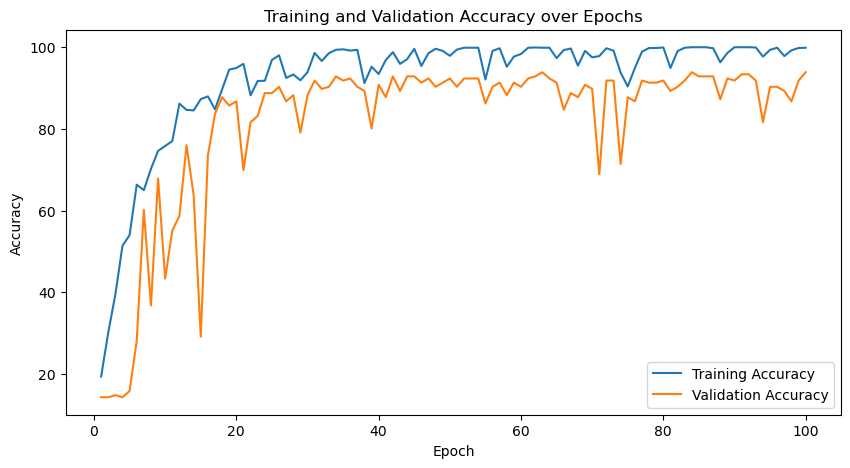

In [13]:
epochs = len(train_accuracies)

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


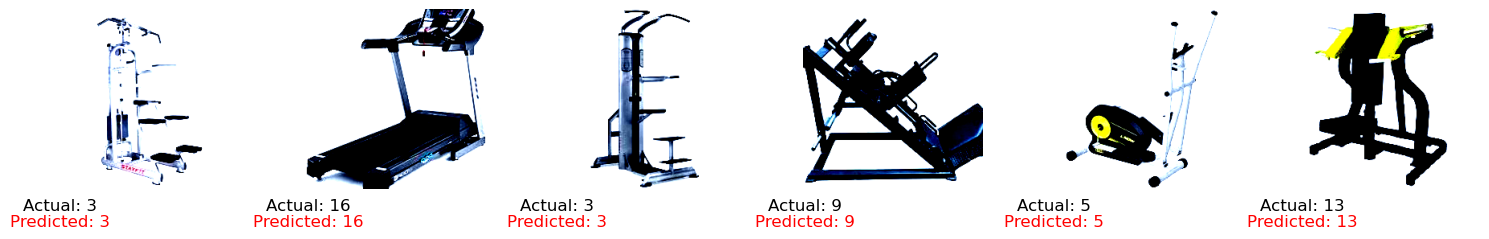

In [16]:
model.eval()

images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

images_np = images.cpu().numpy()
labels_np = labels.cpu().numpy()
predicted_np = predicted.cpu().numpy()

random_indices = random.sample(range(len(images)), 6)

fig, axes = plt.subplots(1, 6, figsize=(15, 20))

for i, idx in enumerate(random_indices):
    image = np.transpose(images_np[idx], (1, 2, 0))
    actual = labels_np[idx]
    pred = predicted_np[idx]

    axes[i].imshow(image)
    axes[i].axis('off')

    axes[i].text(2, image.shape[0] + 20, f'Actual: {actual}', color='black', fontsize=12, ha='center', va='center')
    axes[i].text(2, image.shape[0] + 40, f'Predicted: {pred}', color='red', fontsize=12, ha='center', va='center')

plt.tight_layout()
plt.show()

In [17]:
classnames = [
    "Ab Rotation Machine",
    "Abs-Back Extension Dual Machine",
    "Chess Press Hammer",
    "Dips Machine",
    "Dumbbell & Barbell",
    "Elliptical",
    "Lat Pulldown-Seated Row Dual Machine",
    "Lateral Raise Machine",
    "Leg Abduction Machine",
    "Leg Press Machine",
    "Leg-Hamstring Curl Machine",
    "Pectoral Fly Machine",
    "Preacher Curl",
    "Shoulder Press Machine",
    "Smith & Multipurpose Machine",
    "Stationary Bike",
    "Treadmill"
]

from collections import Counter
num_to_class = {i: classnames[i] for i in range(len(classnames))}

wrong_predictions_mapped = []
for wrong in wrong_predictions:
    for actual, predicted in wrong:
        actual_class = num_to_class[actual]
        predicted_class = num_to_class[predicted]
        wrong_predictions_mapped.append((actual_class, predicted_class))

pair_counts = Counter(wrong_predictions_mapped)

sorted_pairs = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)

print("Sorted wrong predictions by occurrence:")
for pair, count in sorted_pairs:
    print(f"Actual: {pair[0]}, Predicted: {pair[1]}, Occurrences: {count}")

Sorted wrong predictions by occurrence:
Actual: Chess Press Hammer, Predicted: Shoulder Press Machine, Occurrences: 140
Actual: Chess Press Hammer, Predicted: Smith & Multipurpose Machine, Occurrences: 114
Actual: Chess Press Hammer, Predicted: Pectoral Fly Machine, Occurrences: 58
Actual: Leg Press Machine, Predicted: Shoulder Press Machine, Occurrences: 57
Actual: Dumbbell & Barbell, Predicted: Leg Abduction Machine, Occurrences: 55
Actual: Pectoral Fly Machine, Predicted: Smith & Multipurpose Machine, Occurrences: 55
Actual: Shoulder Press Machine, Predicted: Chess Press Hammer, Occurrences: 54
Actual: Elliptical, Predicted: Smith & Multipurpose Machine, Occurrences: 42
Actual: Preacher Curl, Predicted: Lateral Raise Machine, Occurrences: 42
Actual: Smith & Multipurpose Machine, Predicted: Pectoral Fly Machine, Occurrences: 41
Actual: Ab Rotation Machine, Predicted: Smith & Multipurpose Machine, Occurrences: 37
Actual: Lat Pulldown-Seated Row Dual Machine, Predicted: Pectoral Fly Ma

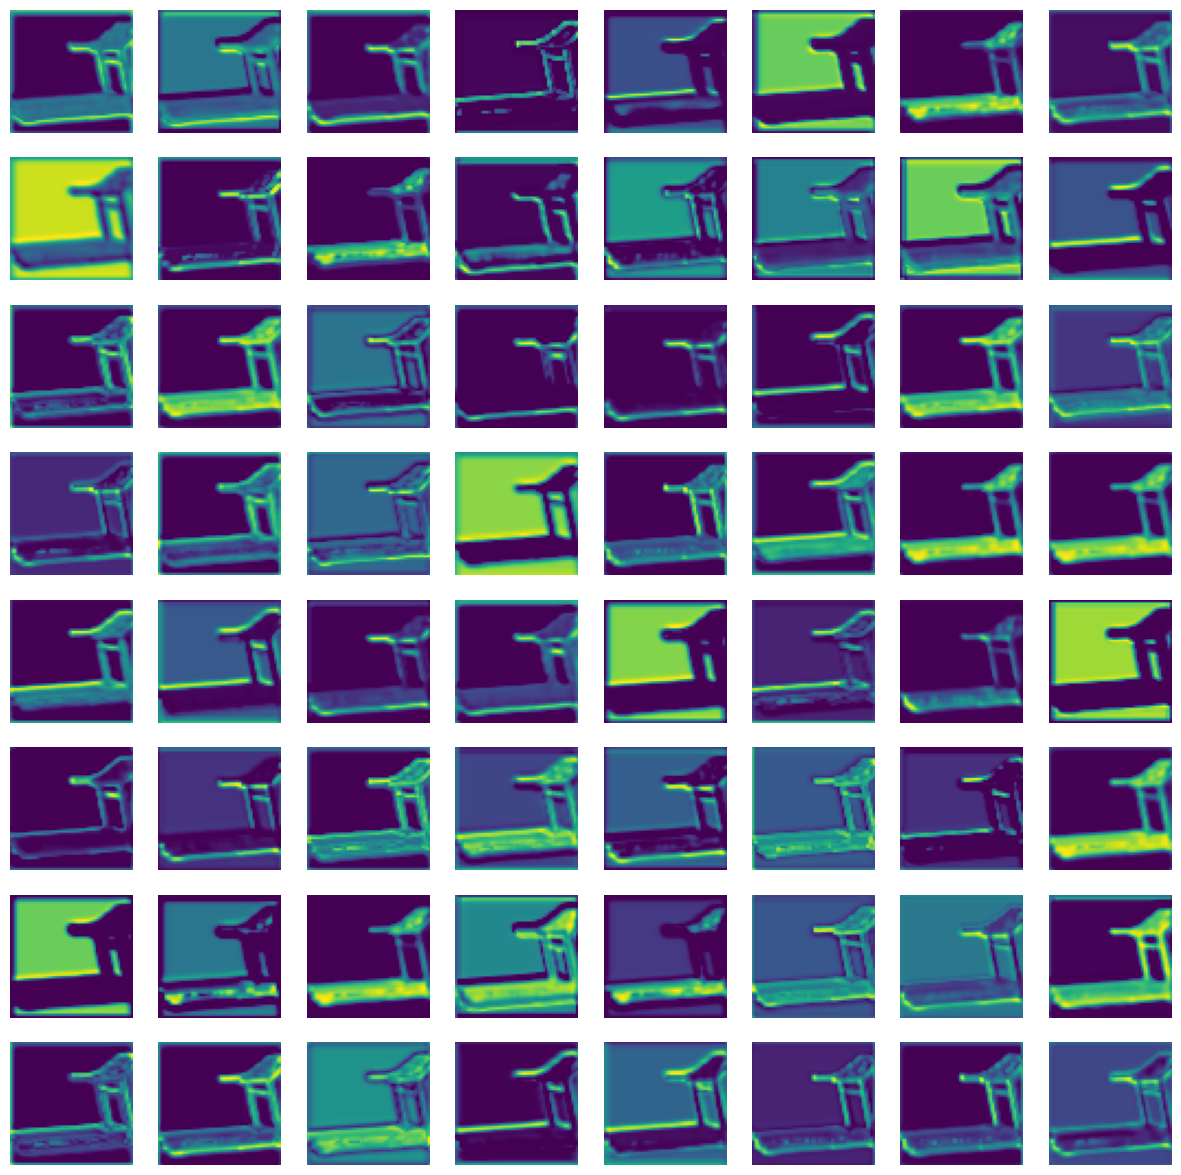

In [18]:
feature_maps = []

def hook_fn(module, input, output):
    feature_maps.append(output)

layer = model.layer1
hook = layer.register_forward_hook(hook_fn)

image_path = 'C:/Users/user/Documents/Deep Learning Projects/Gym Equipment Detector/Datatsets/Treadmill/7.jpg'
image = Image.open(image_path)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)


feature_maps_np = feature_maps[0].squeeze().cpu().numpy()

num_feature_maps = feature_maps_np.shape[0]

grid_size = int(num_feature_maps ** 0.5)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i < num_feature_maps:
        ax.imshow(feature_maps_np[i], cmap='viridis')
        ax.axis('off')

plt.show()

hook.remove()
